In [2]:
import math
import pickle
import requests
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

from multiprocessing import Pool

In [33]:
data_folder = '../data/'
pickle_folder = '../data/pickles/'

In [2]:
characters = pd.read_table(data_folder + 'MovieSummaries/character.metadata.tsv',names=['movie_wiki_id', 'movie_freebase_id', 'release_date_cmu', 'character_name', 'birth_cmu', 'gender_cmu', 'height', 'ethnicity', 'actor_name', 'actor_age', 'freebase_character_actor_map_id', 'freebase_character_id', 'freebase_actor_id' ] , sep='\t', index_col=False)
characters

,movie_wiki_id,movie_freebase_id,release_date_cmu,character_name,birth_cmu,gender_cmu,height,ethnicity,actor_name,actor_age,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [61]:
characters['birth_cmu'] = pd.to_datetime(characters.birth_cmu, errors='ignore')
characters.head()

,movie_wiki_id,movie_freebase_id,release_date_cmu,character_name,birth_cmu,gender_cmu,height,ethnicity,actor_name,actor_age,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [6]:
freebase_wd_mapping = pickle.load(open(pickle_folder + 'freebase_to_wikidata.p', 'rb'))
freebase_wd_mapping.head()

,freebase_id,wikidata_id
0,/m/0695j,Q6718
1,/m/05nrg,Q538
2,/m/0jgd,Q414
3,/m/0d_23,Q2537
4,/m/04g7d,Q315


# Ethnicity from wikidata

In [29]:
ethnicity_wd_id = pd.merge(characters, freebase_wd_mapping, left_on='ethnicity', right_on='freebase_id', how='left')[['ethnicity', 'wikidata_id']]
unique_wikidata_id = ethnicity_wd_id.wikidata_id.unique()
unique_wikidata_id[1:6]

array(['Q49085', 'Q120601', 'Q7325', 'Q1075293', 'Q2643509'], dtype=object)

In [39]:
def get_wikidata(id):
    json_id = requests.get(f'https://www.wikidata.org/wiki/Special:EntityData/{id}.json')
    if json_id.ok:
        json_id = json_id.json()
        key = list(json_id['entities'].keys())[0]
        try:
            return [id, json_id['entities'][key]['labels']['en']['value']]
        except:
            return [id, np.nan]
    else:
        print(json_id.status_code)
        return [id, np.nan]
    # return json_id['entities'][id]['labels']['en']['value']


total_len = len(unique_wikidata_id)

collection = []

with Pool(6) as p:
    collection =  list(tqdm(p.imap(get_wikidata, unique_wikidata_id), total=total_len, smoothing=0.0))
pickle.dump(collection, open(f'temp_ethnicity_names.p','wb'))


  0%|          | 0/355 [00:00<?, ?it/s]

400


100%|██████████| 355/355 [00:19<00:00, 18.14it/s]


In [4]:
collection = pickle.load(open(f'temp_ethnicity_names.p','rb'))

In [5]:
wd_to_ethicity = pd.DataFrame(collection)
wd_to_ethicity.head()

,0,1
0,NaN,NaN
1,Q49085,African Americans
2,Q120601,Omaha people
3,Q7325,Jewish people
4,Q1075293,Irish Americans


In [62]:
characters = pd.merge(pd.merge(characters, freebase_wd_mapping, left_on='ethnicity', right_on='freebase_id', how='left').drop('ethnicity', axis=1), wd_to_ethicity, left_on='wikidata_id', right_on=0, how='left').drop(['wikidata_id', 0], axis=1).rename({1: 'ethnicity'},axis=1)
characters[['actor_name', 'ethnicity']].loc[characters.ethnicity.notna()].head()

,actor_name,ethnicity
2,Ice Cube,African Americans
5,Pam Grier,African Americans
11,Rodney A. Grant,Omaha people
27,Albert Hall,African Americans
55,Seth Green,Jewish people


In [40]:
pickle.dump(characters, open('characters_w_ethnicity.p', 'wb'))

In [42]:
characters = pickle.load(open('characters_w_ethnicity.p', 'rb'))
characters.head()

,movie_wiki_id,movie_freebase_id,release_date_cmu,character_name,birth_cmu,gender_cmu,height,actor_name,actor_age,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN


# Requesting info from wikidata

In [7]:
actors_freebase_wd_id = pd.merge(characters, freebase_wd_mapping, left_on='freebase_actor_id', right_on='freebase_id', how='left')[['freebase_actor_id', 'wikidata_id']]
unique_wikidata_id = actors_freebase_wd_id.wikidata_id.unique()
unique_wikidata_id[1:6]

array(['Q230527', 'Q173637', 'Q169963', 'Q233347', 'Q233862'],
      dtype=object)

In [98]:
wanted_properties = ['P21', 'P569' ,'P172' ,'P800', 'P345']

def get_wikidata(id):
    json_id = requests.get(f'https://www.wikidata.org/wiki/Special:EntityData/{id}.json')
    if json_id.ok:
        json_id = json_id.json()
        key = list(json_id['entities'].keys())[0]
        features = {}
        for prop in wanted_properties:
            try:
                if prop == 'P569':
                    features[prop] = json_id['entities'][key]['claims']['P569'][0]['mainsnak']['datavalue']['value']['time'].removeprefix('+').removesuffix('T00:00:00Z').replace('-00-00','').replace('-00','')
                elif prop == 'P800':
                    features[prop] = len(json_id['entities'][key]['claims']['P800'])
                elif prop == 'P345':
                    features[prop] =  json_id['entities'][key]['claims']['P345'][0]['mainsnak']['datavalue']['value']
                else:
                    features[prop] = json_id['entities'][key]['claims'][prop][0]['mainsnak']['datavalue']['value']['id']
            except:
                pass

        if len(features) == 0:
            features = np.nan
        return [id, features]
    else:
        print(json_id.status_code)
        return [id, np.nan]


total_len = len(unique_wikidata_id)

collection = []

with Pool(6) as p:
    collection =  list(tqdm(p.imap(get_wikidata, unique_wikidata_id), total=total_len, smoothing=0.0))
pickle.dump(collection, open(f'temp_actors_wd_info.p','wb'))


  0%|          | 7/35792 [00:00<1:08:56,  8.65it/s]

400


  2%|▏         | 609/35792 [00:43<41:26, 14.15it/s]

404


 38%|███▊      | 13769/35792 [14:51<23:45, 15.45it/s]

404


 41%|████      | 14671/35792 [15:46<22:42, 15.50it/s]

404


 71%|███████   | 25403/35792 [26:29<10:50, 15.98it/s]

404


 76%|███████▌  | 27215/35792 [28:16<08:54, 16.05it/s]

404


 88%|████████▊ | 31499/35792 [32:23<04:24, 16.20it/s]

404


 89%|████████▉ | 31991/35792 [32:52<03:54, 16.22it/s]

404


100%|██████████| 35792/35792 [36:38<00:00, 16.28it/s]


In [8]:
collection = pickle.load(open(f'temp_actors_wd_info.p','rb'))

In [28]:
def get_year(x):
    try:
        return pd.to_datetime(x['P569']).year
    except:
        return np.nan

def get_feature(x, feature):
    try:
        return x[feature]
    except:
        return np.nan

actors_info = pd.DataFrame(collection)
actors_info.rename({0: 'wikidata_id'}, axis=1, inplace=True)

actors_info['birth_wd'] = actors_info[1].apply(lambda x: get_year(x))
actors_info['gender_wd'] = actors_info[1].apply(lambda x: get_feature(x, 'P21'))
actors_info['actor_imdb_id'] = actors_info[1].apply(lambda x: get_feature(x, 'P345'))
actors_info['number_notable_movies_wd'] = actors_info[1].apply(lambda x: get_feature(x, 'P800'))
actors_info['ethnicity_wd'] = actors_info[1].apply(lambda x: get_feature(x, 'P172'))
actors_info.drop(1, axis=1, inplace=True)
actors_info.head()

,wikidata_id,birth_wd,gender_wd,actor_imdb_id,number_notable_movies_wd,ethnicity_wd
0,Q1873468,1958.0,Q6581072,nm0208962,NaN,NaN
1,Q230527,1974.0,Q6581072,nm0000449,NaN,NaN
2,Q173637,1969.0,Q6581097,nm0001084,NaN,NaN
3,Q169963,1967.0,Q6581097,nm0005458,NaN,NaN
4,Q233347,1977.0,Q6581072,nm0245112,NaN,NaN


In [44]:
characters = pd.merge(pd.merge(characters, freebase_wd_mapping, left_on='freebase_actor_id', right_on='freebase_id', how='left').drop('freebase_id',axis=1), actors_info, left_on='wikidata_id', right_on='wikidata_id', how='left')

In [46]:
pickle.dump(characters, open('characters_w_wd_info.p', 'wb'))

In [34]:
characters = pickle.load(open('characters_w_wd_info.p', 'rb'))
characters.head()

,movie_wiki_id,movie_freebase_id,release_date_cmu,character_name,birth_cmu,gender_cmu,height,actor_name,actor_age,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,ethnicity,wikidata_id,birth_wd,gender_wd,actor_imdb_id,number_notable_movies_wd,ethnicity_wd
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN,Q1873468,1958.0,Q6581072,nm0208962,NaN,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN,Q230527,1974.0,Q6581072,nm0000449,NaN,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans,Q173637,1969.0,Q6581097,nm0001084,NaN,NaN
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN,Q169963,1967.0,Q6581097,nm0005458,NaN,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN,Q233347,1977.0,Q6581072,nm0245112,NaN,NaN


## Get gender label from wikidata

In [11]:
genders = characters.gender_wd.unique()

In [13]:
def get_wikidata(id):
    json_id = requests.get(f'https://www.wikidata.org/wiki/Special:EntityData/{id}.json')
    if json_id.ok:
        json_id = json_id.json()
        key = list(json_id['entities'].keys())[0]
        try:
            return  [id, json_id['entities'][key]['labels']['en']['value']]
        except:
            return [id, np.nan]
    else:
        print(json_id.status_code)
        return [id, np.nan]


total_len = len(genders)

collection = []

with Pool(6) as p:
    collection =  list(tqdm(p.imap(get_wikidata, genders), total=total_len, smoothing=0.0))
pickle.dump(collection, open(f'temp_genders.p','wb'))


  0%|          | 0/11 [00:00<?, ?it/s]

400


100%|██████████| 11/11 [00:01<00:00, 10.17it/s]


In [15]:
collection

[['Q6581072', 'female'],
 ['Q6581097', 'male'],
 [nan, nan],
 ['Q1052281', 'trans woman'],
 ['Q48270', 'non-binary'],
 ['Q18116794', 'genderfluid'],
 ['Q44148', 'male organism'],
 ['Q43445', 'female organism'],
 ['Q12964198', 'genderqueer'],
 ['Q2449503', 'trans man'],
 ['Q27679766', 'transmasculine']]

Male organism -> male
female organism -> female

In [35]:
characters.loc[characters.gender_wd == 'Q44148', 'gender_wd'] = 'Q6581097'
characters.loc[characters.gender_wd == 'Q43445', 'gender_wd'] = 'Q6581072'

In [36]:
gender = pd.DataFrame(collection)
characters = pd.merge(characters, gender, left_on='gender_wd', right_on=0, how='left').drop(['gender_wd', 0], axis=1).rename({1:'gender_wd'}, axis=1)

In [37]:
characters.loc[characters.gender_cmu == 'M', 'gender_cmu'] = 'male'
characters.loc[characters.gender_cmu == 'F', 'gender_cmu'] = 'female'

In [38]:
characters.gender_cmu.value_counts()

male      270257
female    134803
Name: gender_cmu, dtype: int64

In [39]:
characters.gender_wd.value_counts()


male              189609
female             94534
non-binary           109
genderfluid           77
trans woman           69
trans man              7
genderqueer            2
transmasculine         2
Name: gender_wd, dtype: int64

## Merge Gender

In [40]:
characters['combined_gender'] = characters.apply(lambda x: x['gender_wd'] if pd.notna(x['gender_wd']) else x['gender_cmu'], axis=1)
characters[['gender_cmu', 'gender_wd', 'combined_gender']]

,gender_cmu,gender_wd,combined_gender
0,female,female,female
1,female,female,female
2,male,male,male
3,male,male,male
4,female,female,female
...,...,...,...
450664,female,female,female
450665,male,male,male
450666,male,NaN,male
450667,NaN,NaN,NaN


In [41]:
pickle.dump(characters, open('characters_with_gender.p', 'wb'))

In [47]:
characters = pickle.load(open('characters_with_gender.p', 'rb'))
characters.head()

,movie_wiki_id,movie_freebase_id,release_date_cmu,character_name,birth_cmu,gender_cmu,height,actor_name,actor_age,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,ethnicity,wikidata_id,birth_wd,actor_imdb_id,number_notable_movies_wd,ethnicity_wd,gender_wd,combined_gender
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,female,1.620,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN,Q1873468,1958.0,nm0208962,NaN,NaN,female,female
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,female,1.780,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN,Q230527,1974.0,nm0000449,NaN,NaN,female,female
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,male,1.727,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans,Q173637,1969.0,nm0001084,NaN,NaN,male,male
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,male,1.750,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN,Q169963,1967.0,nm0005458,NaN,NaN,male,male
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,female,1.650,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN,Q233347,1977.0,nm0245112,NaN,NaN,female,female


In [43]:
movies = pickle.load(open(pickle_folder + 'movies.p', 'rb'))
movies.head()

,title,primaryTitle,originalTitle,wikipedia_id,freebase_id_cmu,freebase_id_wd,wikidata_id,new_wikidata_id,IMDB_id,mojo_id,...,box_office_cmu,box_office_wd,languages,countries,averageRating_imdb,numVotes_imdb,genres_cmu,genres_imdb,directors,writers
0,Ghosts of Mars,Ghosts of Mars,Ghosts of Mars,975900,/m/03vyhn,/m/03vyhn,Q261700,Q261700,tt0228333,ghostsofmars,...,14010832.0,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",4.9,55061.0,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Action,Horror,Sci-Fi",nm0000118,"nm0837917,nm0000118"
1,Getting Away with Murder: The JonBenét Ramsey ...,Getting Away with Murder: The JonBenet Ramsey ...,Getting Away with Murder: The JonBenet Ramsey ...,3196793,/m/08yl5d,/m/08yl5d,Q16250726,Q16250726,tt0245916,NaN,...,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",5.9,66.0,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",Drama,nm1740285,"nm0334224,nm0003358"
2,Brun bitter,Brun bitter,Brun bitter,28463795,/m/0crgdbh,/m/0crgdbh,Q4978832,Q4978832,tt0094806,NaN,...,NaN,NaN,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}",5.7,40.0,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","Crime,Drama",nm0803751,"nm0803751,nm0820866"
3,White Of The Eye,White of the Eye,White of the Eye,9363483,/m/0285_cd,/m/0285_cd,Q7995657,Q7995657,tt0094320,NaN,...,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}",6.1,2537.0,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","Horror,Thriller",nm0131910,"nm0465026,nm0131910,nm0458461,nm1738738"
4,A Woman in Flames,A Woman in Flames,Die flambierte Frau,261236,/m/01mrr1,/m/01mrr1,Q869644,Q869644,tt0083949,NaN,...,NaN,NaN,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}",6.0,587.0,"{""/m/07s9rl0"": ""Drama""}",Drama,nm0885554,"nm0885554,nm0959016"


In [44]:
characters = pd.merge(characters, movies[['freebase_id_cmu', 'combined_release_year']], left_on='movie_freebase_id', right_on='freebase_id_cmu', how='left').drop('freebase_id_cmu', axis=1)

In [50]:
pickle.dump(characters, open('characters_w_release_year.p', 'wb'))

In [3]:
characters = pickle.load(open('characters_w_release_year.p', 'rb'))
characters.loc[characters.ethnicity_wd.notna()]['ethnicity_wd']

5           Q49085
65         Q161652
84         Q214361
149         Q42740
243        Q974693
            ...   
450471      Q49085
450495    Q1041917
450580     Q170217
450583      Q49085
450655     Q161652
Name: ethnicity_wd, Length: 15289, dtype: object

## Merge ethnicity

In [89]:
wd_to_ethicity

,0,1
0,NaN,NaN
1,Q49085,African Americans
2,Q120601,Omaha people
3,Q7325,Jewish people
4,Q1075293,Irish Americans
...,...,...
350,Q841351,Afrikaners
351,Q46295,peoples of the Caucasus
352,Q2983498,Sierra Leone Creole people
353,Q18973,Georgians


In [7]:
pd.merge(characters, wd_to_ethicity, left_on='ethnicity_wd', right_on=0, how='left').drop(['ethnicity_wd', 0],axis=1).rename({1:'ethnicity_wd'}, axis=1)

,movie_wiki_id,movie_freebase_id,release_date_cmu,character_name,birth_cmu,gender_cmu,height,actor_name,actor_age,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,ethnicity,wikidata_id,birth_wd,actor_imdb_id,number_notable_movies_wd,gender_wd,combined_gender,ethnicity_wd
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,female,1.620,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN,Q1873468,1958.0,nm0208962,NaN,female,female,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,female,1.780,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN,Q230527,1974.0,nm0000449,NaN,female,female,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,male,1.727,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans,Q173637,1969.0,nm0001084,NaN,male,male,NaN
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,male,1.750,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN,Q169963,1967.0,nm0005458,NaN,male,male,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,female,1.650,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN,Q233347,1977.0,nm0245112,NaN,female,female,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,female,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,NaN,Q5298405,1962.0,nm0253528,NaN,female,female,NaN
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,male,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN,Q3809919,1965.0,nm0153068,NaN,male,male,NaN
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,male,1.730,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,English people,NaN,NaN,NaN,NaN,NaN,male,NaN
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
characters.ethnicity.value_counts()

Indians                        16351
African Americans              10159
Jewish people                  10121
English people                  6165
Irish Americans                 3857
                               ...  
Transylvanian Saxons               1
Poles in the United Kingdom        1
Chettiar                           1
Bohemian                           1
Han Chinese people                 1
Name: ethnicity, Length: 354, dtype: int64

In [9]:
characters.ethnicity_wd.value_counts()

Q49085      2902
Q161652     1463
Q7325        987
Q846570      793
Q974693      743
            ... 
Q648255        1
Q2584186       1
Q6510842       1
Q133255        1
Q1003039       1
Name: ethnicity_wd, Length: 204, dtype: int64

In [10]:
characters.ethnicity.notna().sum()

93066

In [11]:
characters.ethnicity_wd.notna().sum()

15289

In [12]:
len(characters.loc[(characters.ethnicity != characters.ethnicity_wd) & (characters.ethnicity.notna() &  characters.ethnicity_wd.notna())])

10168

In [13]:
len(characters.loc[(characters.ethnicity.notna() &  characters.ethnicity_wd.isna())])

82898

In [14]:
len(characters.loc[(characters.ethnicity.isna() &  characters.ethnicity_wd.notna())])

5121

In [15]:
characters['combined_ethnicity'] = characters.apply(lambda x: x['ethnicity'] if pd.notna(x['ethnicity']) else x['ethnicity_wd'], axis=1)
characters[['actor_name', 'ethnicity', 'ethnicity_wd', 'combined_ethnicity']].head()

,actor_name,ethnicity,ethnicity_wd,combined_ethnicity
0,Wanda De Jesus,NaN,NaN,NaN
1,Natasha Henstridge,NaN,NaN,NaN
2,Ice Cube,African Americans,NaN,African Americans
3,Jason Statham,NaN,NaN,NaN
4,Clea DuVall,NaN,NaN,NaN


In [16]:
pickle.dump(characters, open('characters_w_ethnicity.p', 'wb'))

In [17]:
characters = pickle.load(open('characters_w_ethnicity.p', 'rb'))
characters

,movie_wiki_id,movie_freebase_id,release_date_cmu,character_name,birth_cmu,gender_cmu,height,actor_name,actor_age,freebase_character_actor_map_id,...,freebase_actor_id,ethnicity,wikidata_id,birth_wd,actor_imdb_id,number_notable_movies_wd,ethnicity_wd,gender_wd,combined_gender,combined_ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,female,1.620,Wanda De Jesus,42.0,/m/0bgchxw,...,/m/03wcfv7,NaN,Q1873468,1958.0,nm0208962,NaN,NaN,female,female,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,female,1.780,Natasha Henstridge,27.0,/m/0jys3m,...,/m/0346l4,NaN,Q230527,1974.0,nm0000449,NaN,NaN,female,female,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,male,1.727,Ice Cube,32.0,/m/0jys3g,...,/m/01vw26l,African Americans,Q173637,1969.0,nm0001084,NaN,NaN,male,male,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,male,1.750,Jason Statham,33.0,/m/02vchl6,...,/m/034hyc,NaN,Q169963,1967.0,nm0005458,NaN,NaN,male,male,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,female,1.650,Clea DuVall,23.0,/m/02vbb3r,...,/m/01y9xg,NaN,Q233347,1977.0,nm0245112,NaN,NaN,female,female,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,female,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,...,/m/0b_vcv,NaN,Q5298405,1962.0,nm0253528,NaN,NaN,female,female,NaN
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,male,NaN,Jonathan Fahn,27.0,/m/0kr405_,...,/m/0bx7_j,NaN,Q3809919,1965.0,nm0153068,NaN,NaN,male,male,NaN
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,male,1.730,David Hemmings,15.0,/m/0g8ngmc,...,/m/022g44,English people,NaN,NaN,NaN,NaN,NaN,NaN,male,English people
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,...,/m/0g8ngmm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Merge Birth

In [18]:
def get_year(x):
    try:
        return pd.to_datetime(x).year
    except:
        return np.nan

characters['birth_cmu'] = characters.birth_cmu.apply(lambda x: get_year(x))

In [19]:
characters.birth_cmu

0         1958.0
1         1974.0
2         1969.0
3         1967.0
4         1977.0
           ...  
450664    1970.0
450665    1965.0
450666    1941.0
450667       NaN
450668       NaN
Name: birth_cmu, Length: 450669, dtype: float64

In [20]:
imdb_characters = pd.read_csv('../data/IMDB/name.basics.tsv', sep='\t')
imdb_characters.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0053137,tt0031983,tt0072308,tt0050419"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0038355,tt0117057,tt0037382,tt0071877"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0056404,tt0057345,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0080455,tt0072562,tt0077975,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0083922,tt0069467,tt0060827"


In [22]:
characters = pd.merge(characters, imdb_characters, left_on='actor_imdb_id', right_on='nconst', how='left').drop('nconst', axis=1)

,movie_wiki_id,movie_freebase_id,release_date_cmu,character_name,birth_cmu,gender_cmu,height,actor_name,actor_age,freebase_character_actor_map_id,...,number_notable_movies_wd,ethnicity_wd,gender_wd,combined_gender,combined_ethnicity,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958.0,female,1.620,Wanda De Jesus,42.0,/m/0bgchxw,...,NaN,NaN,female,female,NaN,Wanda De Jesus,1958,\N,actress,"tt0100502,tt0140352,tt0228333,tt0309377"
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974.0,female,1.780,Natasha Henstridge,27.0,/m/0jys3m,...,NaN,NaN,female,female,NaN,Natasha Henstridge,1974,\N,"actress,producer,soundtrack","tt0228333,tt0190138,tt0120841,tt0114508"
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969.0,male,1.727,Ice Cube,32.0,/m/0jys3g,...,NaN,NaN,male,male,African Americans,Ice Cube,1969,\N,"soundtrack,actor,producer","tt0195945,tt1408253,tt0113118,tt0101507"
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967.0,male,1.750,Jason Statham,33.0,/m/02vchl6,...,NaN,NaN,male,male,NaN,Jason Statham,1967,\N,"actor,producer,stunts","tt4779682,tt3079380,tt2820852,tt0479884"
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977.0,female,1.650,Clea DuVall,23.0,/m/02vbb3r,...,NaN,NaN,female,female,NaN,Clea DuVall,1977,\N,"actress,writer,producer","tt0228333,tt0133751,tt0179116,tt1024648"


In [23]:
def toInt(x):
    try:
        return int(x)
    except:
        return np.nan

characters['birthYear'] = characters.birthYear.apply(lambda x: toInt(x))
characters.head()

,movie_wiki_id,movie_freebase_id,release_date_cmu,character_name,birth_cmu,gender_cmu,height,actor_name,actor_age,freebase_character_actor_map_id,...,number_notable_movies_wd,ethnicity_wd,gender_wd,combined_gender,combined_ethnicity,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958.0,female,1.620,Wanda De Jesus,42.0,/m/0bgchxw,...,NaN,NaN,female,female,NaN,Wanda De Jesus,1958.0,\N,actress,"tt0100502,tt0140352,tt0228333,tt0309377"
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974.0,female,1.780,Natasha Henstridge,27.0,/m/0jys3m,...,NaN,NaN,female,female,NaN,Natasha Henstridge,1974.0,\N,"actress,producer,soundtrack","tt0228333,tt0190138,tt0120841,tt0114508"
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969.0,male,1.727,Ice Cube,32.0,/m/0jys3g,...,NaN,NaN,male,male,African Americans,Ice Cube,1969.0,\N,"soundtrack,actor,producer","tt0195945,tt1408253,tt0113118,tt0101507"
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967.0,male,1.750,Jason Statham,33.0,/m/02vchl6,...,NaN,NaN,male,male,NaN,Jason Statham,1967.0,\N,"actor,producer,stunts","tt4779682,tt3079380,tt2820852,tt0479884"
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977.0,female,1.650,Clea DuVall,23.0,/m/02vbb3r,...,NaN,NaN,female,female,NaN,Clea DuVall,1977.0,\N,"actress,writer,producer","tt0228333,tt0133751,tt0179116,tt1024648"


In [24]:
characters.keys()

Index(['movie_wiki_id', 'movie_freebase_id', 'release_date_cmu',
       'character_name', 'birth_cmu', 'gender_cmu', 'height', 'actor_name',
       'actor_age', 'freebase_character_actor_map_id', 'freebase_character_id',
       'freebase_actor_id', 'ethnicity', 'wikidata_id', 'birth_wd',
       'actor_imdb_id', 'number_notable_movies_wd', 'ethnicity_wd',
       'gender_wd', 'combined_gender', 'combined_ethnicity', 'primaryName',
       'birthYear', 'deathYear', 'primaryProfession', 'knownForTitles'],
      dtype='object')

In [25]:
def get_combined_birth(x,y,z):
    if abs(x - y) < 10:
        return x
    elif abs(x - z) < 10:
        return x
    elif abs(y - z) < 10:
        return y
    elif pd.notna(x):
        return x
    elif pd.notna(y):
        return y
    elif pd.notna(z):
        return z
    else:
        return np.nan

characters['combined_birth'] = characters.apply(lambda x: get_combined_birth(x['birthYear'], x['birth_wd'], x['birth_cmu']), axis=1)

In [27]:
characters.keys()

Index(['movie_wiki_id', 'movie_freebase_id', 'release_date_cmu',
       'character_name', 'birth_cmu', 'gender_cmu', 'height', 'actor_name',
       'actor_age', 'freebase_character_actor_map_id', 'freebase_character_id',
       'freebase_actor_id', 'ethnicity', 'wikidata_id', 'birth_wd',
       'actor_imdb_id', 'number_notable_movies_wd', 'ethnicity_wd',
       'gender_wd', 'combined_gender', 'combined_ethnicity', 'primaryName',
       'birthYear', 'deathYear', 'primaryProfession', 'knownForTitles',
       'combined_birth'],
      dtype='object')

In [29]:
characters = characters[['movie_wiki_id', 'movie_freebase_id', 'release_date_cmu',
       'character_name', 'actor_name', 'primaryName', 'birth_cmu', 'birth_wd','birthYear', 'combined_birth', 'gender_cmu','gender_wd', 'combined_gender', 'height',
       'actor_age',   'ethnicity', 'ethnicity_wd',
        'combined_ethnicity',

       'deathYear', 'primaryProfession', 'knownForTitles', 'number_notable_movies_wd',  'freebase_character_actor_map_id', 'freebase_character_id',
       'freebase_actor_id','wikidata_id',  'actor_imdb_id',
       ]]
characters.rename({'ethnicity': 'ethnicity_cmu',
       'birthYear':'birth_imdb', 'deathYear' : 'deathYear_imdb'}, axis=1, inplace=True)
characters.head()

,movie_wiki_id,movie_freebase_id,release_date_cmu,character_name,actor_name,primaryName,birth_cmu,birth_wd,birth_imdb,combined_birth,...,combined_ethnicity,deathYear_imdb,primaryProfession,knownForTitles,number_notable_movies_wd,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,wikidata_id,actor_imdb_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,Wanda De Jesus,Wanda De Jesus,1958.0,1958.0,1958.0,1958.0,...,NaN,\N,actress,"tt0100502,tt0140352,tt0228333,tt0309377",NaN,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,Q1873468,nm0208962
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,Natasha Henstridge,Natasha Henstridge,1974.0,1974.0,1974.0,1974.0,...,NaN,\N,"actress,producer,soundtrack","tt0228333,tt0190138,tt0120841,tt0114508",NaN,/m/0jys3m,/m/0bgchn4,/m/0346l4,Q230527,nm0000449
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,Ice Cube,Ice Cube,1969.0,1969.0,1969.0,1969.0,...,African Americans,\N,"soundtrack,actor,producer","tt0195945,tt1408253,tt0113118,tt0101507",NaN,/m/0jys3g,/m/0bgchn_,/m/01vw26l,Q173637,nm0001084
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,Jason Statham,Jason Statham,1967.0,1967.0,1967.0,1967.0,...,NaN,\N,"actor,producer,stunts","tt4779682,tt3079380,tt2820852,tt0479884",NaN,/m/02vchl6,/m/0bgchnq,/m/034hyc,Q169963,nm0005458
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,Clea DuVall,Clea DuVall,1977.0,1977.0,1977.0,1977.0,...,NaN,\N,"actress,writer,producer","tt0228333,tt0133751,tt0179116,tt1024648",NaN,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,Q233347,nm0245112


In [30]:
characters

,movie_wiki_id,movie_freebase_id,release_date_cmu,character_name,actor_name,primaryName,birth_cmu,birth_wd,birth_imdb,combined_birth,...,combined_ethnicity,deathYear_imdb,primaryProfession,knownForTitles,number_notable_movies_wd,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,wikidata_id,actor_imdb_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,Wanda De Jesus,Wanda De Jesus,1958.0,1958.0,1958.0,1958.0,...,NaN,\N,actress,"tt0100502,tt0140352,tt0228333,tt0309377",NaN,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,Q1873468,nm0208962
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,Natasha Henstridge,Natasha Henstridge,1974.0,1974.0,1974.0,1974.0,...,NaN,\N,"actress,producer,soundtrack","tt0228333,tt0190138,tt0120841,tt0114508",NaN,/m/0jys3m,/m/0bgchn4,/m/0346l4,Q230527,nm0000449
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,Ice Cube,Ice Cube,1969.0,1969.0,1969.0,1969.0,...,African Americans,\N,"soundtrack,actor,producer","tt0195945,tt1408253,tt0113118,tt0101507",NaN,/m/0jys3g,/m/0bgchn_,/m/01vw26l,Q173637,nm0001084
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,Jason Statham,Jason Statham,1967.0,1967.0,1967.0,1967.0,...,NaN,\N,"actor,producer,stunts","tt4779682,tt3079380,tt2820852,tt0479884",NaN,/m/02vchl6,/m/0bgchnq,/m/034hyc,Q169963,nm0005458
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,Clea DuVall,Clea DuVall,1977.0,1977.0,1977.0,1977.0,...,NaN,\N,"actress,writer,producer","tt0228333,tt0133751,tt0179116,tt1024648",NaN,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,Q233347,nm0245112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,Dorothy Elias-Fahn,Dorothy Elias-Fahn,1970.0,1962.0,1962.0,1962.0,...,NaN,\N,"actress,sound_department,miscellaneous","tt0113568,tt0988824,tt0079833,tt0182629",NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,Q5298405,nm0253528
450665,913762,/m/03pcrp,1992-05-21,Hibiki,Jonathan Fahn,Jonathan Fahn,1965.0,1965.0,1965.0,1965.0,...,NaN,\N,"actor,director,sound_department","tt4902250,tt1130090,tt0301921,tt0301290",NaN,/m/0kr405_,/m/0kr4090,/m/0bx7_j,Q3809919,nm0153068
450666,28308153,/m/0cp05t9,1957,NaN,David Hemmings,NaN,1941.0,NaN,NaN,1941.0,...,English people,NaN,NaN,NaN,NaN,/m/0g8ngmc,NaN,/m/022g44,NaN,NaN
450667,28308153,/m/0cp05t9,1957,NaN,Roberta Paterson,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,NaN,NaN


percentage of movie_wiki_id filled: 1.000%
percentage of movie_freebase_id filled: 1.000%
percentage of release_date_cmu filled: 0.978%
percentage of combined_release_year filled: 0.992%
percentage of character_name filled: 0.428%
percentage of actor_name filled: 0.997%
percentage of primaryName filled: 0.627%
percentage of birth_cmu filled: 0.764%
percentage of birth_wd filled: 0.630%
percentage of birth_imdb filled: 0.616%
percentage of combined_birth filled: 0.777%
percentage of gender_cmu filled: 0.899%
percentage of gender_wd filled: 0.631%
percentage of combined_gender filled: 0.902%
percentage of height filled: 0.344%
percentage of actor_age filled: 0.649%
percentage of actor_age_from_combined filled: 0.770%
percentage of ethnicity_cmu filled: 0.207%
percentage of ethnicity_wd filled: 0.034%
percentage of combined_ethnicity filled: 0.218%
percentage of deathYear_imdb filled: 0.627%
percentage of primaryProfession filled: 0.626%
percentage of knownForTitles filled: 0.627%
percent

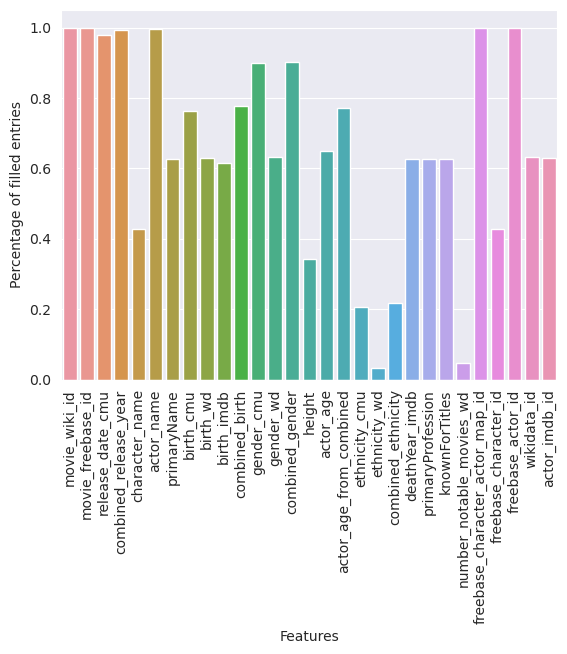

In [63]:
def get_percentage_notna(df, feature):
   return print(f'percentage of {feature} filled: {df[feature].notna().sum() / len(df):.3f}%')

features = list(characters.keys())

for feature in features:
    get_percentage_notna(characters, feature)

tempdict = {}
for feature in features:
   tempdict[feature] =  characters[feature].notna().sum() / len(characters)

tempdf = pd.DataFrame([tempdict])

ax = sns.barplot(data=tempdf)
ax.set_ylabel('Percentage of filled entries')
ax.set_xlabel('Features')
ax.tick_params('x', labelrotation=90)

In [34]:
pickle.dump(characters, open(pickle_folder + 'characters.p', 'wb'))

In [60]:
characters['release_date_cmu'] = characters.release_date_cmu.apply(lambda x: get_year(x))

In [62]:
characters = characters[['movie_wiki_id', 'movie_freebase_id', 'release_date_cmu', 'combined_release_year',
       'character_name', 'actor_name', 'primaryName', 'birth_cmu', 'birth_wd',
       'birth_imdb', 'combined_birth', 'gender_cmu', 'gender_wd',
       'combined_gender', 'height', 'actor_age',  'actor_age_from_combined', 'ethnicity_cmu',
       'ethnicity_wd', 'combined_ethnicity', 'deathYear_imdb',
       'primaryProfession', 'knownForTitles', 'number_notable_movies_wd',
       'freebase_character_actor_map_id', 'freebase_character_id',
       'freebase_actor_id', 'wikidata_id', 'actor_imdb_id',
       ]]

In [58]:
def get_age(birth, release):
    try:
        return release - birth
    except:
        return np.nan

characters['actor_age_from_combined'] = characters.apply(lambda x: get_age(x['combined_birth'], x['combined_release_year']), axis=1)

In [64]:
pickle.dump(characters, open('../data/pickles/characters.p', 'wb'))
